<a href="https://colab.research.google.com/github/ZackYovel/GA-for-Hyper-Parameter-Tuning/blob/MLK/GA_multy_pop_med_pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Genetic Algorithm for Hyper Parameter Tuning

## Using data from the kaggle Housing Prices Competition for Kaggle Learn Users

Using multiple populations.

Competition URL: https://www.kaggle.com/c/home-data-for-ml-course

In [ ]:
# Imports
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import concurrent.futures
import random
import json
import os
import heapq
import time
import logging

random_gen = default_rng()

In [ ]:
# Data load
project_files_path = os.path.join("drive", "My Drive", "Colab Notebooks", "GA_multy_pop_med_pressure")

train = pd.read_csv(os.path.join(project_files_path, "train.csv"))
X_test = pd.read_csv(os.path.join(project_files_path, "test.csv"))

X = train.drop(['SalePrice'], axis=1)
y = train.SalePrice

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Preprocess data

numerical_columns = [col for col in X_train.columns if X_train[col].dtype != 'object']
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']

most_frequent_num_imputer = SimpleImputer(strategy='most_frequent')
most_frequent_cat_imputer = SimpleImputer(strategy='most_frequent')

low_cardinality_cols = [col for col in categorical_columns if X_train[col].nunique() < 10]
high_cardinality_cols = set(categorical_columns) - set(low_cardinality_cols)
good_label_cols = [col for col in high_cardinality_cols if set(X_train[col]).issuperset(set(X_cv[col]))]

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

ordinal_encoder = OrdinalEncoder()

numerical_transformer = most_frequent_num_imputer

categorical_low_card_transformer = Pipeline(
    steps=[
           ('impute', most_frequent_cat_imputer),
           ('encode', OH_encoder)
    ]
)

categorical_high_card_transformer = Pipeline(
    steps=[
           ('impute', most_frequent_cat_imputer),
           ('encode', ordinal_encoder)
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
                  ('num', numerical_transformer, numerical_columns),
                  ('cat_low_card', categorical_low_card_transformer, low_cardinality_cols),
                  ('cat_high_card', categorical_high_card_transformer, good_label_cols)
    ]
)


X_train_prepped = preprocessor.fit_transform(X_train)
X_cv_prepped = preprocessor.transform(X_cv)
X_test_prepped = preprocessor.transform(X_test)

In [ ]:
def model_from_hp(hp):
  return RandomForestRegressor(n_estimators=hp['n_estimators'],
                               criterion='mae',
                               max_depth=hp['max_depth'],
                               min_samples_split=hp['min_samples_split'],
                               min_samples_leaf=hp['min_samples_leaf'],
                               min_weight_fraction_leaf=hp['min_weight_fraction_leaf'],
                               max_features=hp['max_features'],
                               max_leaf_nodes=hp['max_leaf_nodes'],
                               min_impurity_decrease=hp['min_impurity_decrease'],
                               bootstrap=hp['bootstrap'],
                               oob_score=hp['oob_score'],
                               n_jobs=-1,
                               ccp_alpha=hp['ccp_alpha'],
                               max_samples=hp['max_samples'])

## Hyper Parameter Tuning Using a Genetic Algorithm

### Algorithm Description:
1. Prepare generation 0: initialize n_territories teritories each of which has pop_size instances of hyper parameter sets with random values in it's population.
2. For each generation (steps 3-16):
3. For each teritory (steps 4-14):
4. For each specimen in the population (steps 5-7):
5. Build a model based on the specimen
6. Evaluate the model
7. While unevaluated specimen remain go back to step 4.
8. Breed population until it reaches pop_size:
9. While population size is less than pop_size (steps 10-13):
10. Randomly select two distinct parent specimen (give higher chances to reproduce to specimen with better fit value).
11. Create a new specimen by randomly "inheriting" hyper parameter values from the parents
12. Mutate the new specimen:
for numerical hyper parameters add a value chosen randomly from a normal ditribution with mean 0 and standard deviation of approximately mutation_factor times the size of the range of legal values.
for boolean hyper parameters choose randomly giving the existing value a probability of 1 - mutation_factor to be chosen again.
13. While population size is less than pop_size return to step 9
14. While not all teritories processed return to step 3
15. Compute: mutation_factor = 0.1 * (number of teritories that need drift + 1)
(a population needs drift if the average improvement of it's n_survivors best specimen is less than drift_threshold)
16. While not processed all generations go back to step 2.
17. Return best set of hyper parameters.

**************************************************************************************************** 
Generation 83/500
.......................................
Best MAE for teritory 3 is 22478.896096116463 . Average improvement is 0.0
...........................................................................
Best MAE for teritory 5 is 20432.351455479453 . Average improvement is -0.0018345316482595297
.
Best MAE for teritory 0 is 26225.603979688236 . Average improvement is 0.0
................................Finished evaluating teritory 3
Finished evaluating teritory 5
Finished evaluating teritory 0
.
Best MAE for teritory 1 is 23314.14145430541 . Average improvement is -0.008563456929764901
Finished evaluating teritory 1
.
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.009580787851348305
Finished evaluating teritory 4
.
Best MAE for teritory 2 is 19014.63707952816 . Average improvement is 0.0
Finished evaluating teritory 2
Need drift: 5
This generation took 0:

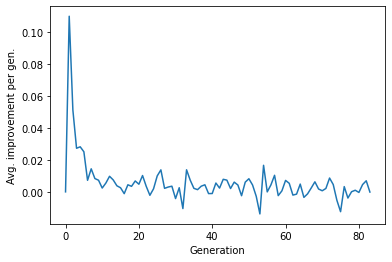

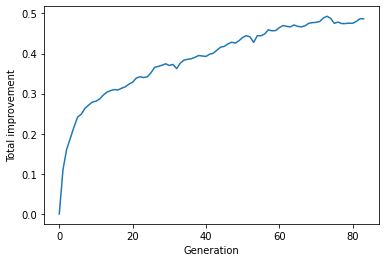

**************************************************************************************************** 
Generation 84/500
...................................................................
Best MAE for teritory 0 is 26225.603979688236 . Average improvement is 0.0016357002502063178
..
Best MAE for teritory 1 is 23314.14145430541 . Average improvement is -0.04707490116557633
...............................................
Best MAE for teritory 2 is 19014.63707952816 . Average improvement is 0.0341417499661667
....................
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is -0.04342004277713096
........
Best MAE for teritory 3 is 22478.896096116463 . Average improvement is 0.023876348588868
...Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 4
Finished evaluating teritory 3
...
Best MAE for teritory 5 is 20432.351455479453 . Average improvement is 0.01992964777038586
Finished evaluating terit

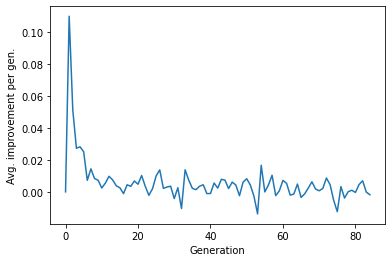

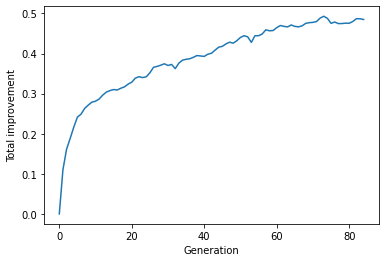

**************************************************************************************************** 
Generation 85/500
........................................................................................
Best MAE for teritory 1 is 23314.14145430541 . Average improvement is 0.03497391070250577
..
Best MAE for teritory 2 is 19014.63707952816 . Average improvement is 0.004821254714471701
...
Best MAE for teritory 0 is 23159.001187444068 . Average improvement is 0.013914072806538114
......................................................Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 0
.
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is -0.040823745856879534
Finished evaluating teritory 4
.
Best MAE for teritory 3 is 22478.896096116463 . Average improvement is 0.0
Finished evaluating teritory 3
.
Best MAE for teritory 5 is 20432.351455479453 . Average improvement is 0.0
Finished evaluating teritory 5
Need drift: 3
This gene

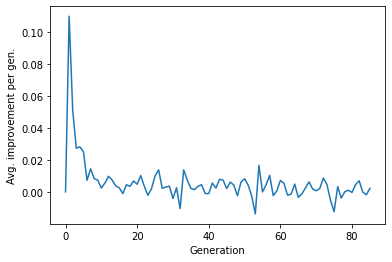

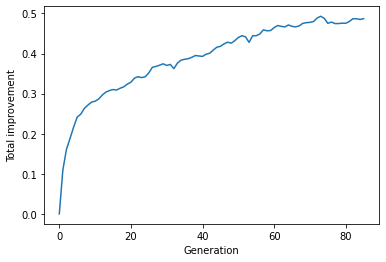

**************************************************************************************************** 
Generation 86/500
.......................................
Best MAE for teritory 0 is 23159.001187444068 . Average improvement is 0.0
........................................................................
Best MAE for teritory 5 is 20432.351455479453 . Average improvement is 0.0
....
Best MAE for teritory 1 is 22478.896096116463 . Average improvement is 0.02757259257550193
.......................
Best MAE for teritory 3 is 24524.948236086435 . Average improvement is -0.046823489719151956
.........Finished evaluating teritory 0
Finished evaluating teritory 5
Finished evaluating teritory 1
Finished evaluating teritory 3
..
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.003150804698292209
Finished evaluating teritory 4
.
Best MAE for teritory 2 is 19014.63707952816 . Average improvement is 0.0
Finished evaluating teritory 2
Need drift: 4
This generation took 0:07

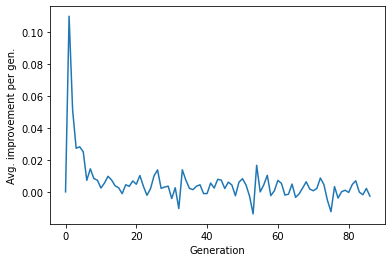

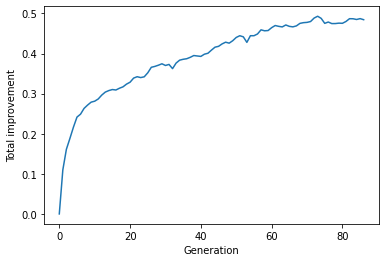

**************************************************************************************************** 
Generation 87/500
.....................................
Best MAE for teritory 0 is 23159.001187444068 . Average improvement is 0.03053615061960624
..........................................................
Best MAE for teritory 1 is 22478.896096116463 . Average improvement is 0.00258570753315146
........................
Best MAE for teritory 2 is 19014.63707952816 . Average improvement is -0.05233594979886569
...................
Best MAE for teritory 3 is 24524.948236086435 . Average improvement is -0.051878091493841705
.........Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
.
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.04609346786567947
Finished evaluating teritory 4
..
Best MAE for teritory 5 is 20432.351455479453 . Average improvement is 0.014978067201886214
Finished evaluating t

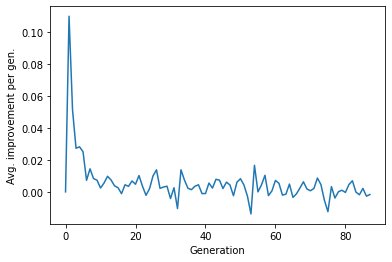

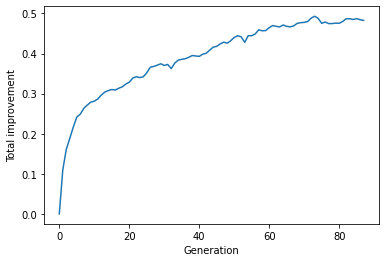

**************************************************************************************************** 
Generation 88/500
............................................................
Best MAE for teritory 0 is 23159.001187444068 . Average improvement is 0.001543366122737977
.......
Best MAE for teritory 1 is 22478.896096116463 . Average improvement is 0.003398973947257078
.............................................
Best MAE for teritory 2 is 19014.63707952816 . Average improvement is 0.026285431298733952
........
Best MAE for teritory 3 is 24524.948236086435 . Average improvement is -0.005401453964430147
..........................Finished evaluating teritory 0
Finished evaluating teritory 1
.Finished evaluating teritory 2
Finished evaluating teritory 3
..
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.0
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 20432.351455479453 . Average improvement is 0.0
Finished evaluating teritory 5
Need drift: 3
This ge

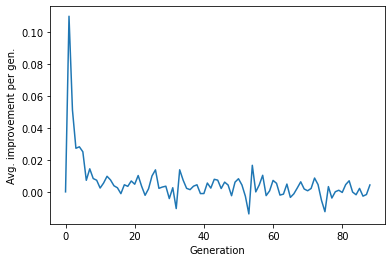

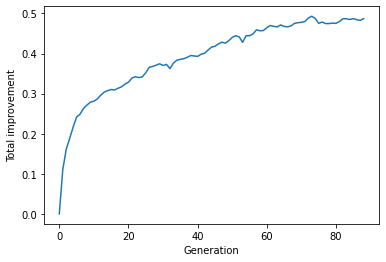

**************************************************************************************************** 
Generation 89/500
.....................................
Best MAE for teritory 0 is 23159.001187444068 . Average improvement is 0.0
................................................
Best MAE for teritory 1 is 22478.896096116463 . Average improvement is -0.0958426130739588
................................
Best MAE for teritory 3 is 24524.948236086435 . Average improvement is 0.034478414708897676
..
Best MAE for teritory 2 is 19014.63707952816 . Average improvement is 0.045036967098325276
........................
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.048745985396555946
....Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 2
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 24768.59445180017 . Average improvement is -0.05208648247695902
Finished evaluating teritory 5
Need dr

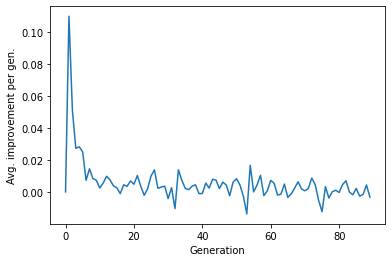

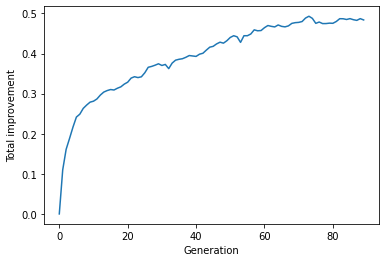

**************************************************************************************************** 
Generation 90/500
..........................................................
Best MAE for teritory 0 is 23159.001187444068 . Average improvement is 0.0
.....
Best MAE for teritory 1 is 22478.896096116463 . Average improvement is 0.08542945480378372
........................................................
Best MAE for teritory 2 is 19014.63707952816 . Average improvement is -0.03613467611173138
.........................
Best MAE for teritory 3 is 24524.948236086435 . Average improvement is 0.015124795671795921
...Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
..
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.0
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 24768.59445180017 . Average improvement is -0.013566241065922191
Finished evaluating teritory 5
Need drift: 4
This gene

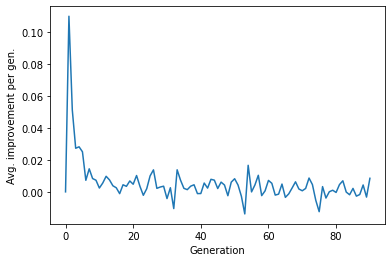

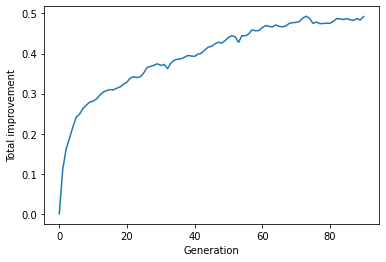

**************************************************************************************************** 
Generation 91/500
..............................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.03911403667915647
........................
Best MAE for teritory 0 is 23159.001187444068 . Average improvement is 0.019160847074751075
........
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is -0.01949904614945641
.......................
Best MAE for teritory 3 is 24524.948236086435 . Average improvement is -0.01496429871985172
....................
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is -0.034294306131785524
..........Finished evaluating teritory 1
Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 3
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 24768.59445180017 . Average improvement is 0.015354702576313217
Finished evaluating 

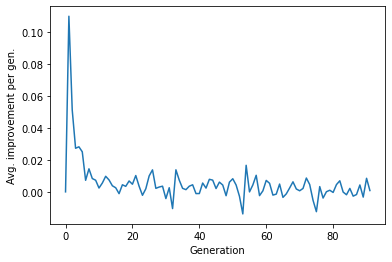

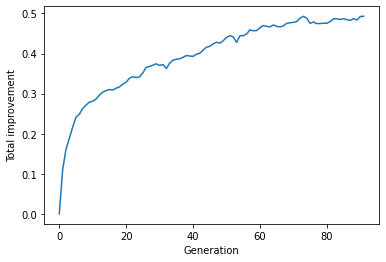

**************************************************************************************************** 
Generation 92/500
........................................
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is -0.01998345474045149
............................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.005886243774111843
........
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.04678392177292512
.............................
Best MAE for teritory 3 is 23159.001187444068 . Average improvement is 0.01735551798016055
.........................
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.0006836506162262168
.Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 24768.59445180017 . Average improvement is 0.0
Finished evaluating teritory 5
Need dr

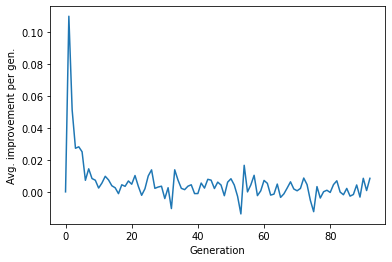

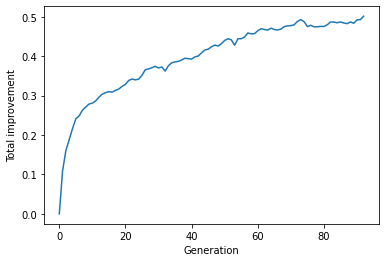

**************************************************************************************************** 
Generation 93/500
.........................................
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is 0.0
..........................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0040175739051919734
.................................
Best MAE for teritory 3 is 23159.001187444068 . Average improvement is 0.03907234808955207
...
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.0
........................
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.012659459419331887
....Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 2
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 24768.59445180017 . Average improvement is -0.016939444745959875
Finished evaluating teritory 5
Need drift: 3
This gen

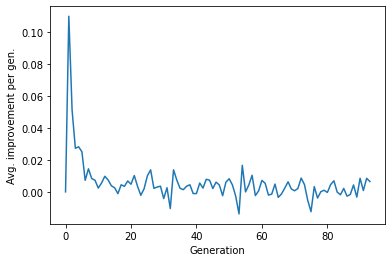

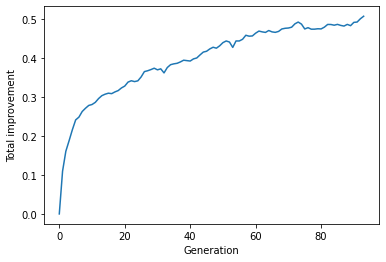

**************************************************************************************************** 
Generation 94/500
.................................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0
................................
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is -0.013600530512811404
........................................
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.0020289930713095483
..........Finished evaluating teritory 1
Finished evaluating teritory 0
Finished evaluating teritory 4
.
Best MAE for teritory 3 is 23159.001187444068 . Average improvement is 0.0
Finished evaluating teritory 3
.
Best MAE for teritory 5 is 24768.59445180017 . Average improvement is 0.03235466719287605
Finished evaluating teritory 5
.
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.0
Finished evaluating teritory 2
Need drift: 4
This generation took 0:07

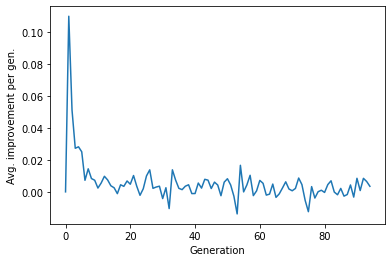

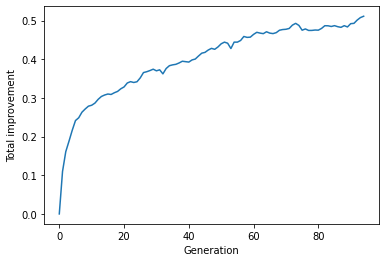

**************************************************************************************************** 
Generation 95/500
.......................................
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is -0.020089749596822415
................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.016071393369310072
...............................
Best MAE for teritory 3 is 23159.001187444068 . Average improvement is -0.0038151573493629964
.................
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.002366162542726702
............Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 4
..
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.0346385150436439
Finished evaluating teritory 2
.
Best MAE for teritory 5 is 24768.59445180017 . Average improvement is -0.030322023329240166
Finished evaluati

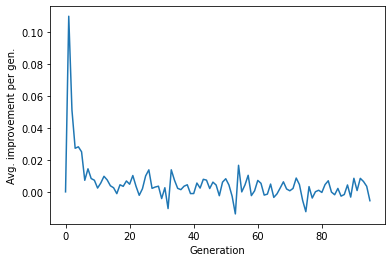

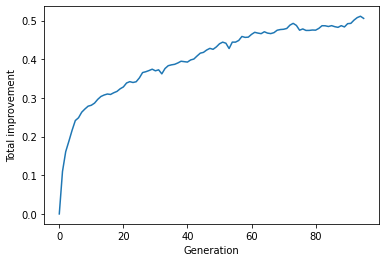

**************************************************************************************************** 
Generation 96/500
...................................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0
....
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is 0.014359012563140539
....................
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.0
.................................
Best MAE for teritory 3 is 23159.001187444068 . Average improvement is 0.018090000486645552
.......................Finished evaluating teritory 1
Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 3
..
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is -0.028018822521259645
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 24768.59445180017 . Average improvement is 0.021729337060316434
Finished evaluating teritory 5
Need drift: 3
This gen

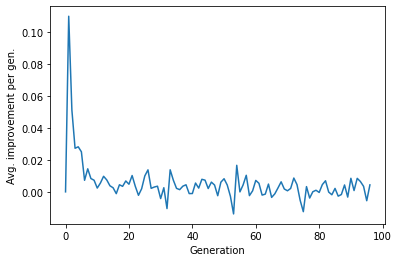

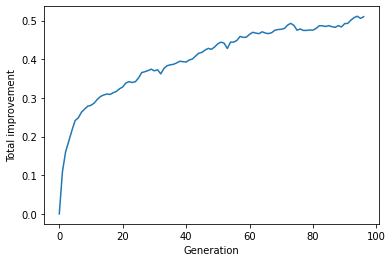

**************************************************************************************************** 
Generation 97/500
..................................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.017074007339623054
........................
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.002065740642398506
......
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is 0.0005166022123284097
....................
Best MAE for teritory 3 is 23159.001187444068 . Average improvement is 0.002027665906896736
..............................Finished evaluating teritory 1
.Finished evaluating teritory 2
Finished evaluating teritory 0
Finished evaluating teritory 3
.
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.031995656522647575
Finished evaluating teritory 4
..
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.031234807297859435
Finished evaluati

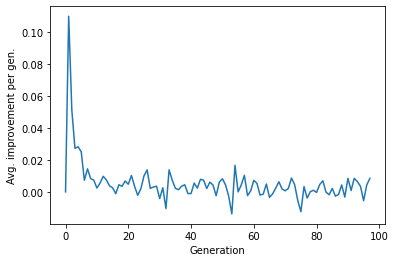

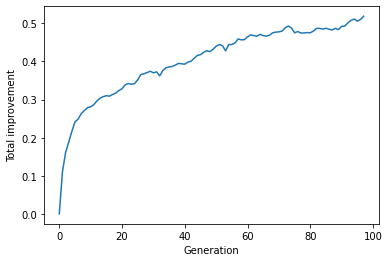

**************************************************************************************************** 
Generation 98/500
................................................................
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is 0.0
............................
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.001753473689199092
.
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.02216447581572467
.....................
Best MAE for teritory 3 is 23159.001187444068 . Average improvement is 0.0090296643193859
.................................Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 1
Finished evaluating teritory 3
.
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.021645658792406097
Finished evaluating teritory 5
..
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.002991571241826696
Finished evaluating teritory 4
Need dr

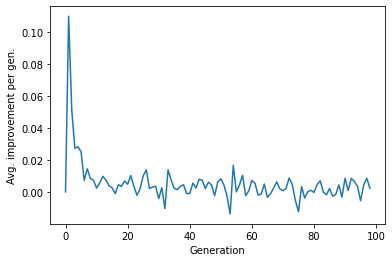

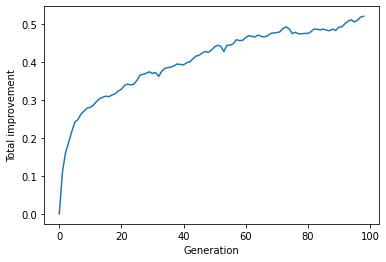

**************************************************************************************************** 
Generation 99/500
...................................................................
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is 0.02587279868497494
...........................
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.017645604122080494
.......................
Best MAE for teritory 3 is 23159.001187444068 . Average improvement is -0.010360405715049592
..............................Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 3
.
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.025681197941368472
Finished evaluating teritory 1
.
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.027104165783594425
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.0
Finished evaluating teritory 5
Need 

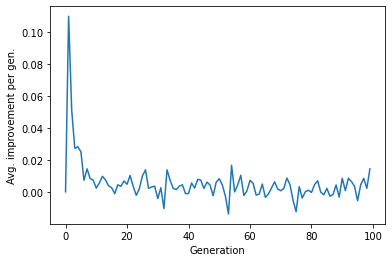

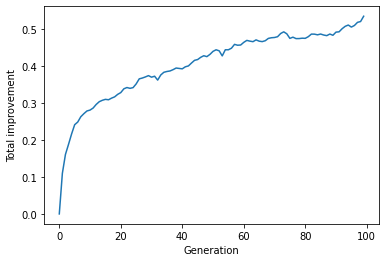

**************************************************************************************************** 
Generation 100/500
................................................................
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is -0.02121962384557652
.
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0
..............................................
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.0
.............................
Best MAE for teritory 3 is 23159.001187444068 . Average improvement is -0.015251728416055488
.......Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
..
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is -0.014148605650054047
Finished evaluating teritory 5
.
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.0
Finished evaluating teritory 4
Need drift: 6
This generation took 0

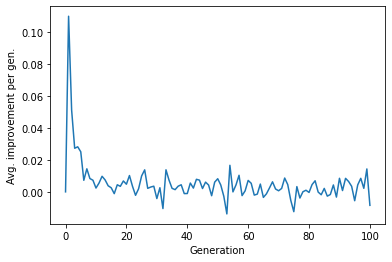

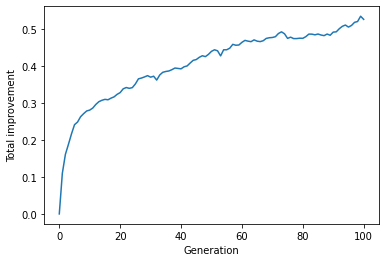

**************************************************************************************************** 
Generation 101/500
...............................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.028130496986048303
..
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is -0.023183185848705823
.........................
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is -0.031054978598311855
.............................................
Best MAE for teritory 3 is 23159.001187444068 . Average improvement is 0.0006902733072509104
...
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is 0.0
.........Finished evaluating teritory 1
Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 3
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is -0.029786863642002448
Finished evaluating teritory 5


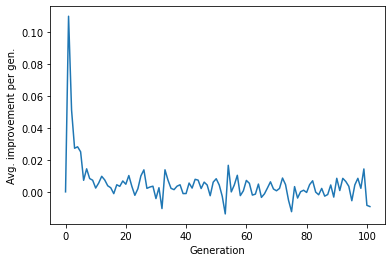

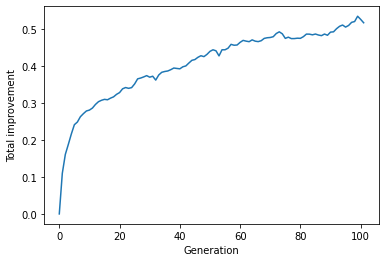

**************************************************************************************************** 
Generation 102/500
.............................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.040619298908052714
............................
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.0036475886271578606
...................
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is -0.0775526155726366
...........
Best MAE for teritory 3 is 23159.001187444068 . Average improvement is -0.0013334424910141918
............................Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 0
Finished evaluating teritory 3
..
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is -0.04439883723714355
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.0
Finished evaluating teritory 5
N

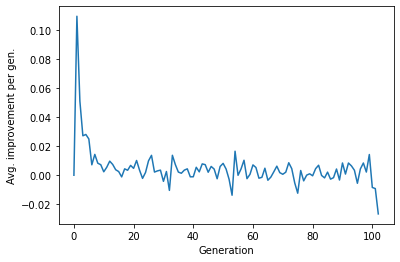

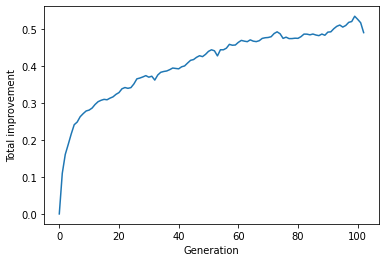

**************************************************************************************************** 
Generation 103/500
..............................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.08691842926883386
........
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is 0.04173285460733189
.......................................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is -0.04479526304602799
........
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is -0.03600428878738027
...........................
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is -0.017596358561495662
...Finished evaluating teritory 1
Finished evaluating teritory 0
Finished evaluating teritory 3
Finished evaluating teritory 4
Finished evaluating teritory 2
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.10184741005403519
Finished evaluating t

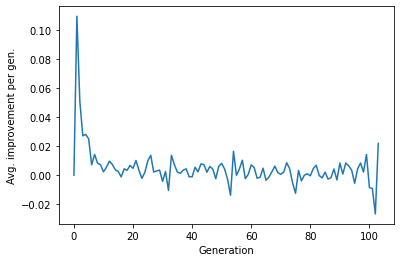

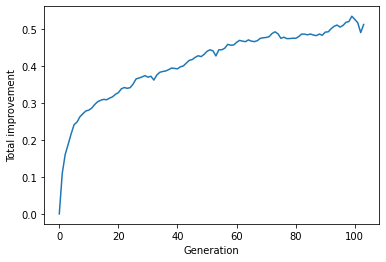

**************************************************************************************************** 
Generation 104/500
.........................................
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is 0.04837454065853897
...........................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.03609656058441868
..........................
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.015122440270318949
.....................................................Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
.
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.03485523985793337
Finished evaluating teritory 3
.
Best MAE for teritory 4 is 21312.52633793824 . Average improvement is -0.02583426857990856
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.0
Finished evaluating teritory 5
Need dr

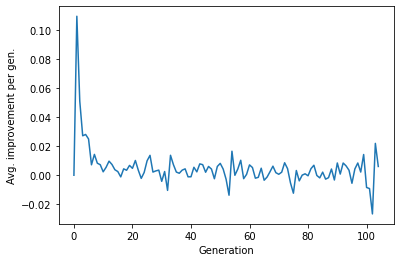

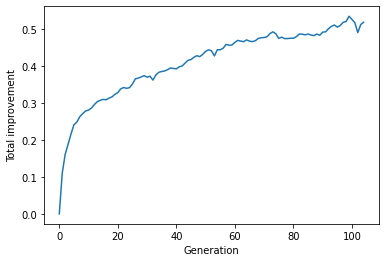

**************************************************************************************************** 
Generation 105/500
..........................................
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is 0.002649495080999653
.........................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.005066689026793636
........................
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.040323051609454374
...........................................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is -0.033222454196825346
...........
Best MAE for teritory 4 is 23314.14145430541 . Average improvement is -0.04172911547282199
..Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is -0.024458161038390824
Finished evaluati

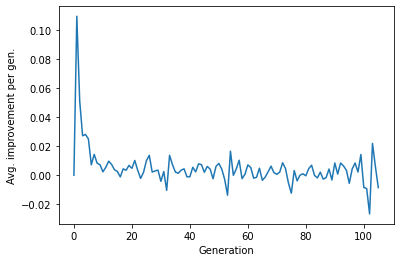

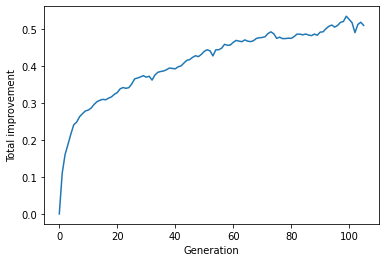

**************************************************************************************************** 
Generation 106/500
..............................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.016106914540150452
...
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is 0.003103280648987905
.........................
Best MAE for teritory 2 is 20432.351455479453 . Average improvement is 0.029771154348956053
.......................................................
Best MAE for teritory 4 is 23314.14145430541 . Average improvement is -0.04180792631219732
..Finished evaluating teritory 1
Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 4
..
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.0080337098847989
Finished evaluating teritory 5
.
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is -0.058400428295541706
Finished evaluating 

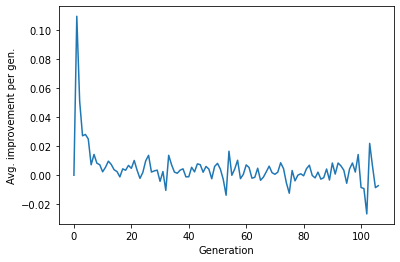

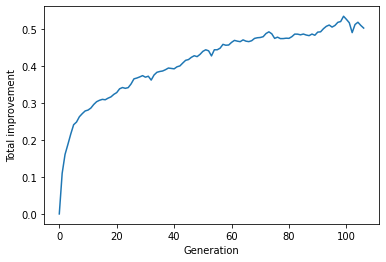

**************************************************************************************************** 
Generation 107/500
..........................................
Best MAE for teritory 0 is 23755.490092420885 . Average improvement is 0.0
...........................................
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is -0.057927684911550426
........
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.02026682505468047
................................................
Best MAE for teritory 4 is 20432.351455479453 . Average improvement is 0.08620882258936358
...
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.007298910847264972
...Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 1
Finished evaluating teritory 4
Finished evaluating teritory 3
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.001781141024220334
Finished evaluating teritory 5
Need d

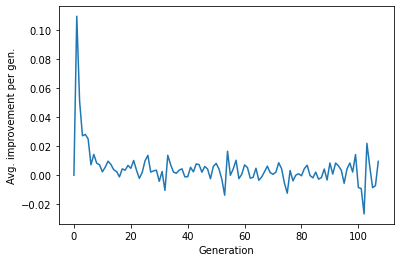

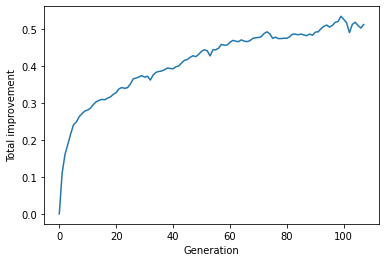

**************************************************************************************************** 
Generation 108/500
....................................
Best MAE for teritory 0 is 23671.902044170583 . Average improvement is 0.02101913561138602
...........................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.018974214557215596
....
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is -0.0005183900333455282
...........................................
Best MAE for teritory 4 is 20432.351455479453 . Average improvement is 0.014461239409746085
.
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is 0.043008638742269456
....Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 4
Finished evaluating teritory 3
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.002619435067318321
Finished evaluat

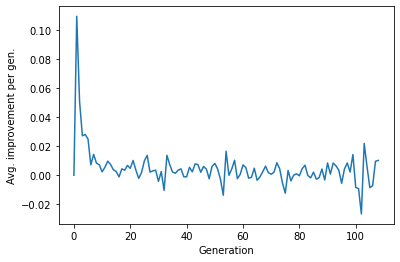

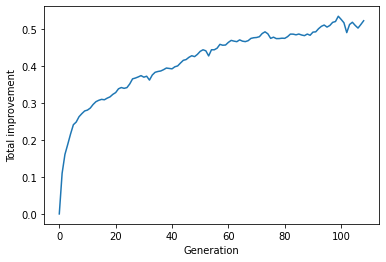

**************************************************************************************************** 
Generation 109/500
.................................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.013207842288615712
.......................
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.004135879725431835
...............................
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is -0.02705805525344418
................
Best MAE for teritory 0 is 23671.902044170583 . Average improvement is 0.02222146786607726
............Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
Finished evaluating teritory 0
..
Best MAE for teritory 4 is 20432.351455479453 . Average improvement is 0.003514248561154565
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.005348335989622255
Finished evaluating

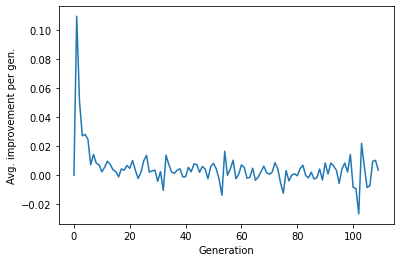

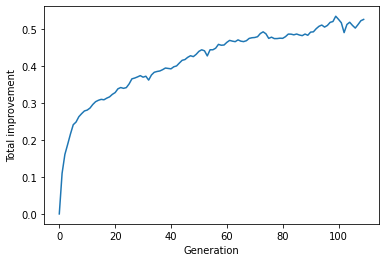

**************************************************************************************************** 
Generation 110/500
.....................................................................
Best MAE for teritory 0 is 23671.902044170583 . Average improvement is 0.0
...............
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0022310127655054135
.....
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.012112953922129854
.........................
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is 0.005439578724597105
.................................Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
.
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is -0.010220339065419193
Finished evaluating teritory 5
..
Best MAE for teritory 4 is 20432.351455479453 . Average improvement is 0.0
Finished evaluating teritory 4
Need drift: 3
This 

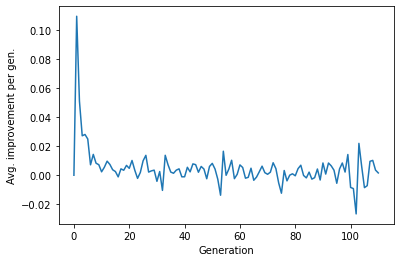

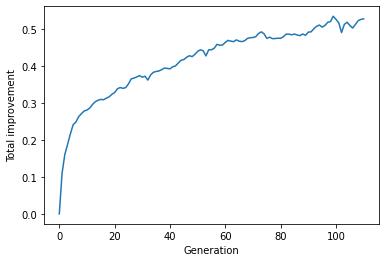

**************************************************************************************************** 
Generation 111/500
............................................................
Best MAE for teritory 0 is 23671.902044170583 . Average improvement is -0.025498998769782233
...........................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.029914609546792148
...........................
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is 0.03677986769243602
.
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.0
...........................
Best MAE for teritory 4 is 20432.351455479453 . Average improvement is 0.000981732462257856
.....Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 2
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.018679266271885986
Finished evaluating teritory 5
Nee

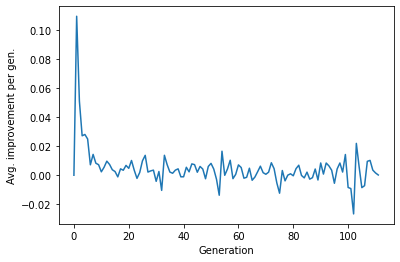

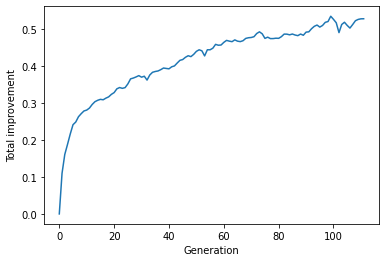

**************************************************************************************************** 
Generation 112/500
.........................................
Best MAE for teritory 0 is 23671.902044170583 . Average improvement is -0.004525107683750584
...........................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.01162711901430069
............
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.0
...................................................
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is 0.021355230877338816
Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
..
Best MAE for teritory 4 is 20432.351455479453 . Average improvement is 0.0
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.0
Finished evaluating teritory 5
Need drift: 4
This generation took 0:0

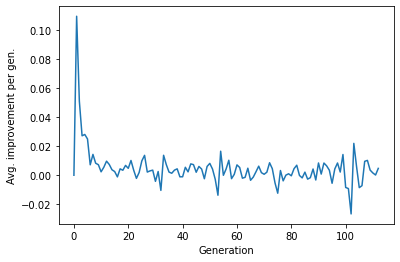

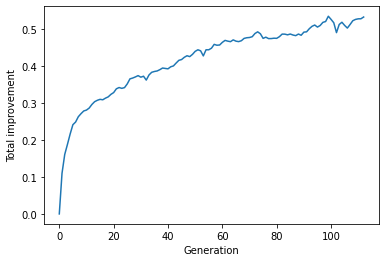

**************************************************************************************************** 
Generation 113/500
...............................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.006913300030038316
........................
Best MAE for teritory 0 is 23671.902044170583 . Average improvement is 0.014012707505856481
.........................
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is -0.0414824310518741
.........................
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is 0.0004459032404311447
.......
Best MAE for teritory 4 is 20432.351455479453 . Average improvement is 0.004971082624034562
...Finished evaluating teritory 1
Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 3
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.0
Finished evaluating teritory 5
Need

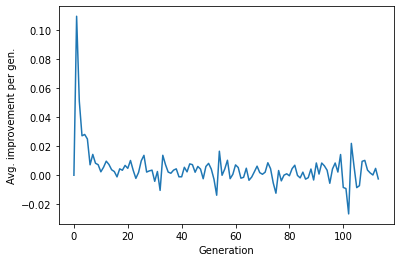

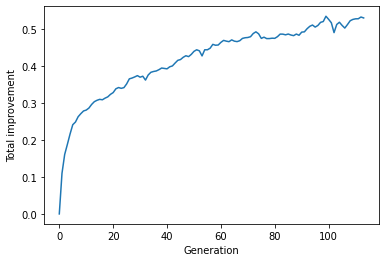

**************************************************************************************************** 
Generation 114/500
.......................................
Best MAE for teritory 0 is 23671.902044170583 . Average improvement is 0.0
.................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.00438315686012003
..............................................
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is 0.0
....
Best MAE for teritory 4 is 20432.351455479453 . Average improvement is 0.013736910973656258
.........Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 4
..
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.022039999003233612
Finished evaluating teritory 2
.
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.0
Finished evaluating teritory 5
Need drift: 4
This generation took 0:0

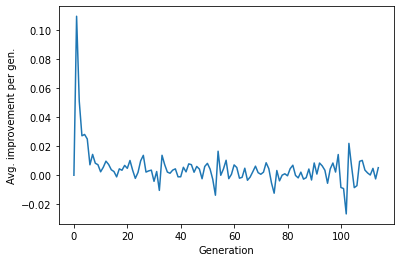

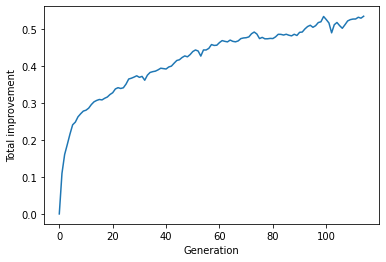

**************************************************************************************************** 
Generation 115/500
.......................................
Best MAE for teritory 0 is 23671.902044170583 . Average improvement is 0.007043680342182723
...............................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.007883631254189671
.
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.0
......................................................
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is -0.025422897651084186
......Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
.
Best MAE for teritory 4 is 20432.351455479453 . Average improvement is -0.0012900444211081386
Finished evaluating teritory 4
..
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is -0.01560761279228795
Finished evaluating teritory 5
N

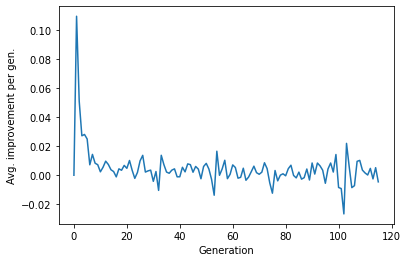

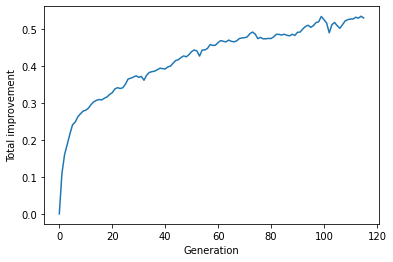

**************************************************************************************************** 
Generation 116/500
.................................................................
Best MAE for teritory 0 is 23671.902044170583 . Average improvement is 0.0
....................................................
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.018008360894915088
.
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.022478550650573914
.................
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.0
............Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 1
Finished evaluating teritory 5
..
Best MAE for teritory 4 is 20432.351455479453 . Average improvement is 0.007496513206622479
Finished evaluating teritory 4
.
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is 0.021678251093607548
Finished evaluating teritory 3
Need drift: 3
This g

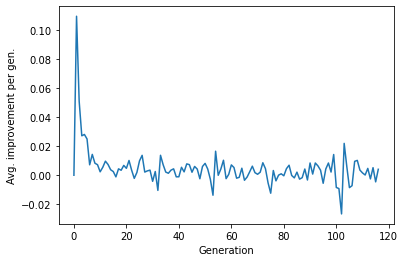

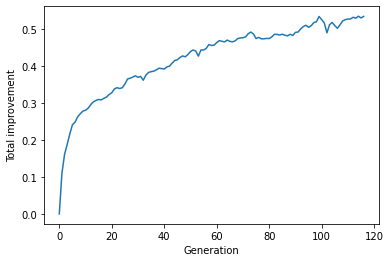

**************************************************************************************************** 
Generation 117/500
.....................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is -0.042755988764050734
..........................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.030216246338362174
.................................
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is 0.0280031666741265
.....................
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.0
..............Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 2
..
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.007402074564264671
Finished evaluating teritory 5
.
Best MAE for teritory 4 is 20432.351455479453 . Average improvement is -0.017758057167327257
Finished evaluating teritory 4
Need

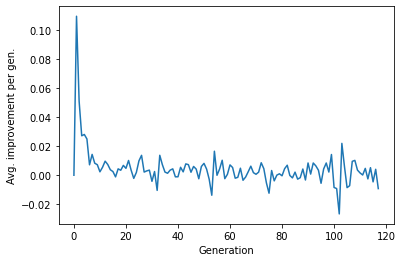

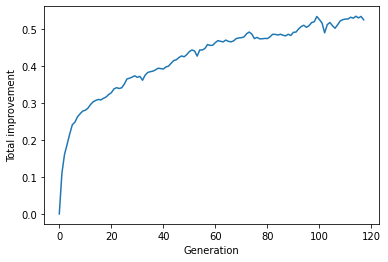

**************************************************************************************************** 
Generation 118/500
.........................................
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is 0.05909862472631677
.............................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.010680313057729762
...........................................
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is 0.008010018882741665
.
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.0
.................................Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 2
.
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.03413084687517931
Finished evaluating teritory 5
..
Best MAE for teritory 4 is 25742.659789733392 . Average improvement is -0.05440543987395152
Finished evaluating teritory 4
Need d

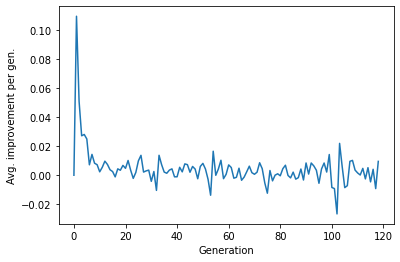

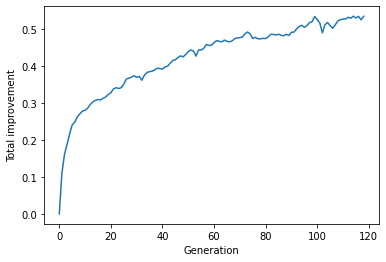

**************************************************************************************************** 
Generation 119/500
.......................................
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is 0.018698679657918715
................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.02746447120681461
.....
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is -0.026704051745064183
................................................
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is 0.0
.......Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
..
Best MAE for teritory 4 is 25742.659789733392 . Average improvement is -0.014816222992918182
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.0
Finished evaluating teritory 5
Need drift: 4
This g

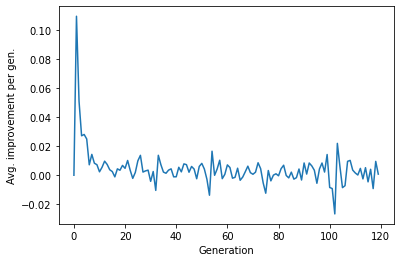

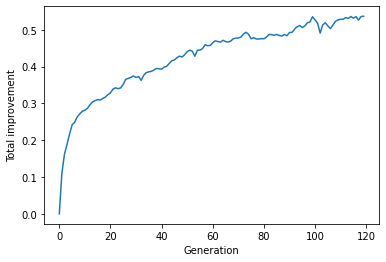

**************************************************************************************************** 
Generation 120/500
...........................................
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is -0.003661093035872698
.................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0
.....
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is -0.014747342382559814
.......................
Best MAE for teritory 3 is 24341.415913589248 . Average improvement is 0.0
...........................Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
..
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is -0.03602491039419253
Finished evaluating teritory 5
.
Best MAE for teritory 4 is 25742.659789733392 . Average improvement is 7.54509674001369e-05
Finished evaluating teritory 4
Need drift: 5
This 

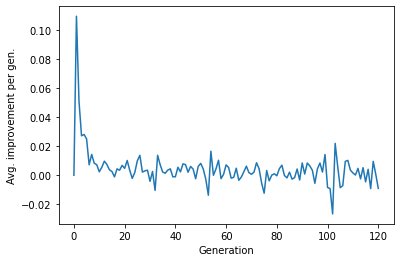

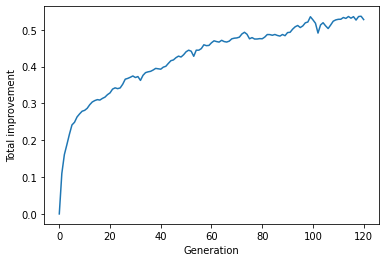

**************************************************************************************************** 
Generation 121/500
............................................................
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is -0.04532473303148932
.....
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.003905512287691204
..........................
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is -0.021281293718208527
.........................................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is -0.03216383612206519
.....
Best MAE for teritory 4 is 25742.659789733392 . Average improvement is 0.035299176977310553
..........Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.01260945695235094
Finished evaluatin

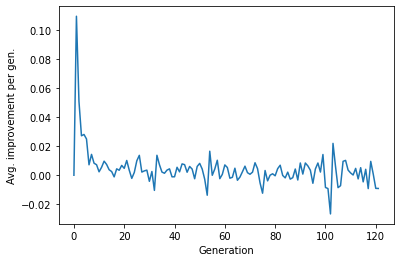

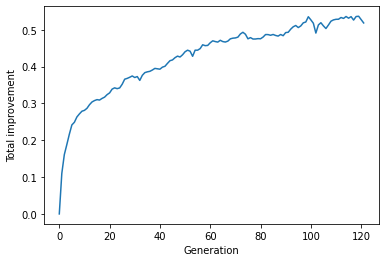

**************************************************************************************************** 
Generation 122/500
...................................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.029604667717192612
........................
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.008768380400693943
.........................
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is 0.04433718816377463
...
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.01755939434248588
.......................
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is -0.06626384658093132
.....Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 0
Finished evaluating teritory 3
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.017670243904001293
Finished evaluating t

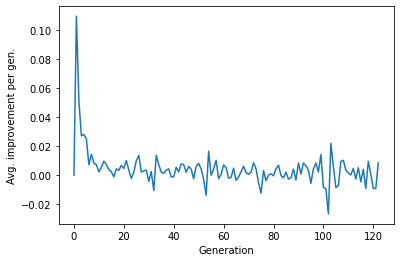

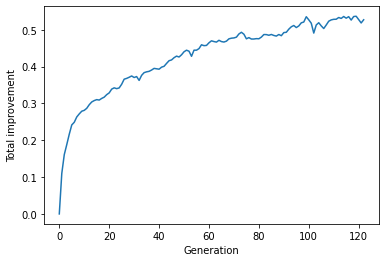

**************************************************************************************************** 
Generation 123/500
...........................................
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is 0.007039394617263106
..............................................
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.0
..
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.01061151678565464
............................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.016212172698758964
............................
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.02154790424053865
Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.0
Finished evaluating teritory 5
Need drift: 2
This gener

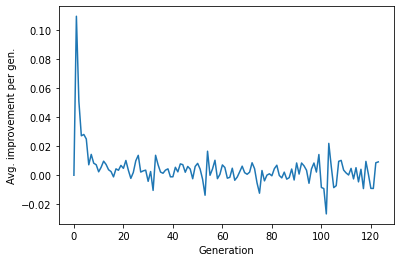

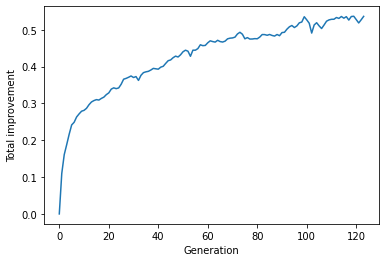

**************************************************************************************************** 
Generation 124/500
.......................................................................
Best MAE for teritory. 1 .is 19014.63707952816 .. Average improvement is 0.023234558471238564
...
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is 0.0016983188047787756
.................................
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is -0.025859655317961527
............................
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.0025703518033468598
.........Finished evaluating teritory 1
Finished evaluating teritory 0
Finished evaluating teritory 5
Finished evaluating teritory 2
..
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.0
Finished evaluating teritory 3
.
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.002647769726445315
Finished evaluating teritory 4
Ne

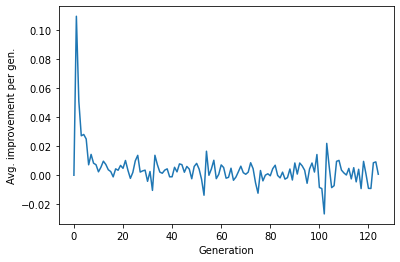

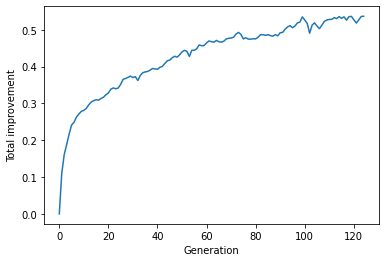

**************************************************************************************************** 
Generation 125/500
.................................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0
............................................
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is 0.0
.........................
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.012732281658623501
.............Finished evaluating teritory 1
Finished evaluating teritory 0
Finished evaluating teritory 2
.
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is -0.005457208578020456
Finished evaluating teritory 5
.
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.020674217974703035
Finished evaluating teritory 4
.
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is -0.015893948100141997
Finished evaluating teritory 3
Need drift: 4
This g

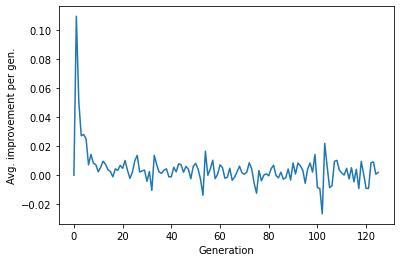

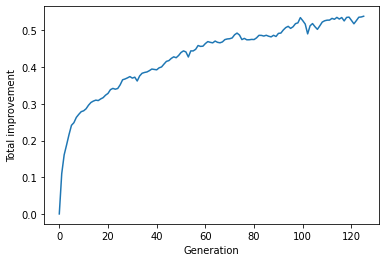

**************************************************************************************************** 
Generation 126/500
.......................................
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is -0.014056319544898832
...............................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.04185758064786582
..............
Best MAE for teritory.. 2.. is. 21312.52633793824.. . Average improvement is. 0.0110353160455674
.............................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is -0.025304693700608505
....
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.01258949484314309
......Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.015740903178674603
Finished evaluating 

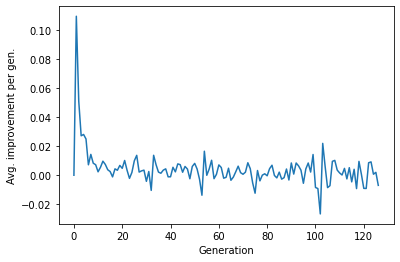

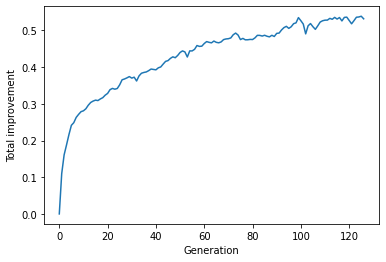

**************************************************************************************************** 
Generation 127/500
.............................................
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is 0.0019080929626273946
..................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.013623538807032043
..............
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.032749258166280715
...................................
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is -0.0058384478968723785
..
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is -0.000809326130256971
.Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.008039883128158065
Finished evalua

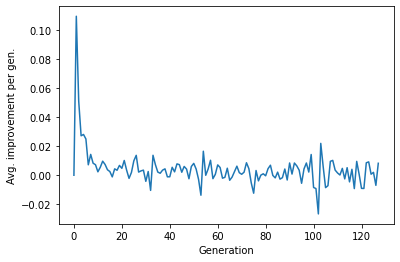

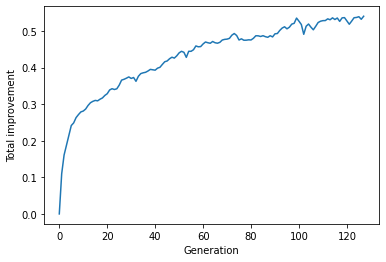

**************************************************************************************************** 
Generation 128/500
.............................................................
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is 0.0
...
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0
...................................................
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.0
.
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.0005681904010368388
..............................
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.024473506963859526
.Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is -0.008686583930553882
Finished evaluating teritory 5
Need drift: 4
This generation took 0:

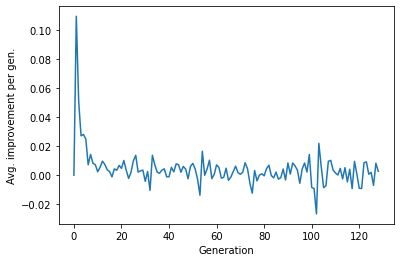

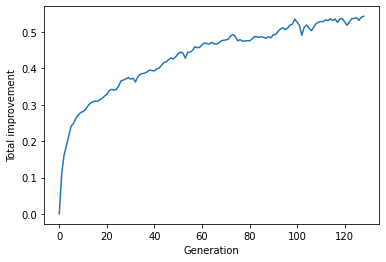

**************************************************************************************************** 
Generation 129/500
.............................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.015015064418042234
...................................
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is -0.030308580082788916
......................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.02376985451937874
.
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is 0.0
.........................
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.0129474572753705
...Finished evaluating teritory 1
Finished evaluating teritory 0
Finished evaluating teritory 3
Finished evaluating teritory 2
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.0
Finished evaluating teritory 5
Need drift: 4
This gene

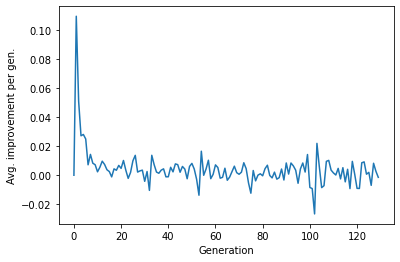

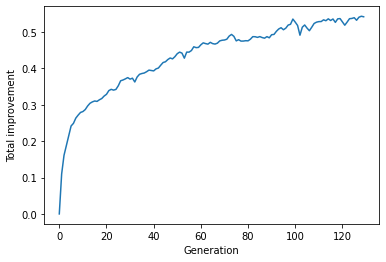

**************************************************************************************************** 
Generation 130/500
.....................................
Best MAE for teritory 0 is 20432.351455479453 . Average improvement is 0.057793622706502124
..................................................
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is -0.024555792067809556
..........................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.07269006547508017
.
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.01125652984860337
.................................Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 1
Finished evaluating teritory 3
..
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.0
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.015298284035037524
Finished evaluating teritory 5
Need 

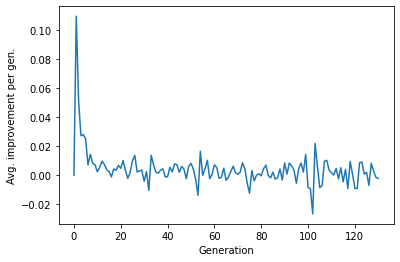

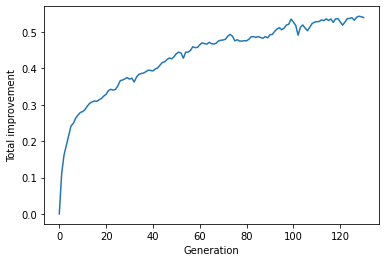

**************************************************************************************************** 
Generation 131/500
...........................................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is -0.05125911621798951
...
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0686783598409646
.................................................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.02567542296240899
.....
Best MAE for teritory 2 is 21312.52633793824 . Average improvement is -0.024065830227009477
...............................Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 2
..
Best MAE for teritory 5 is 22478.896096116463 . Average improvement is 0.0
Finished evaluating teritory 5
.
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.0
Finished evaluating teritory 4
Need drift: 4
This genera

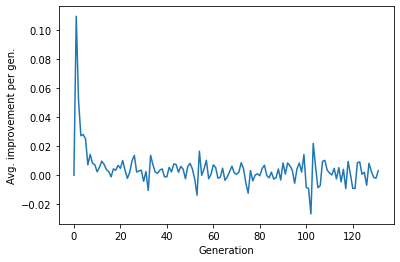

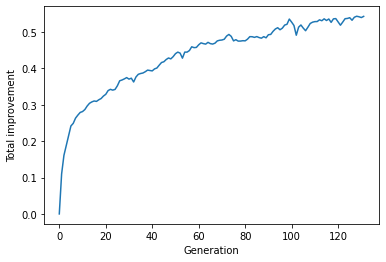

**************************************************************************************************** 
Generation 132/500
............................................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is 0.015351673074680772
.
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.0343754769514647
....................................................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.00042678481567226534
...........................
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.00662168755060355
.......Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 4
..
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is 0.02652493921181276
Finished evaluating teritory 5
.
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is -0.041924439630814714
Finished evaluating t

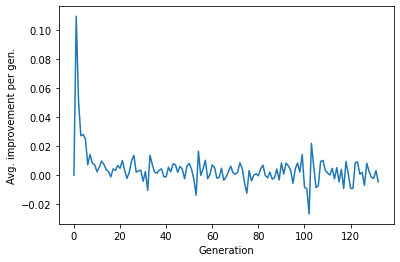

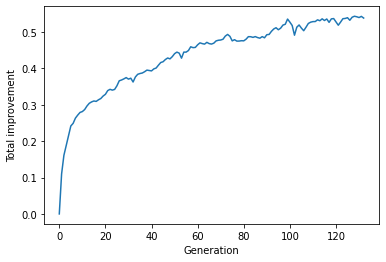

**************************************************************************************************** 
Generation 133/500
..............................................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is -0.04367714579622084
.
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.04383410023315526
...............................
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is 0.031222401394531252
.....................................................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.0
Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
.
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.0
Finished evaluating teritory 4
..
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is 0.0
Finished evaluating teritory 5
Need drift: 4
This generation took 0:09:10

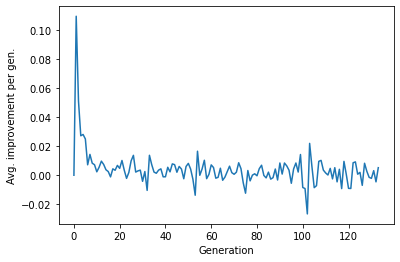

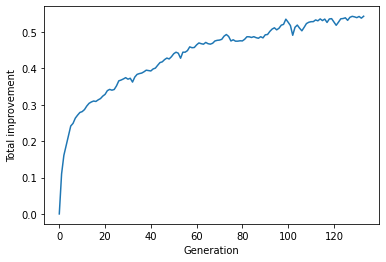

**************************************************************************************************** 
Generation 134/500
.........................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is 0.03331484239817106
.............................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.031707301668065346
...........................................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.0
....................
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is -0.014321812311786308
..............Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 2
..
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is -0.008078296993280998
Finished evaluating teritory 5
.
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.0
Finished evaluating teritory 4
Need drift: 4
This gene

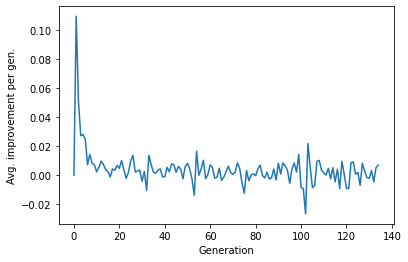

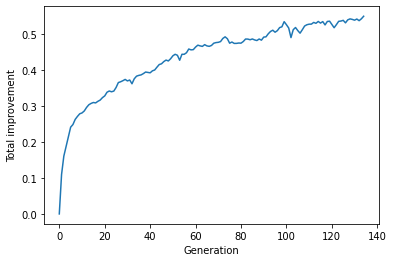

**************************************************************************************************** 
Generation 135/500
............................................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is -0.0467565564137723
....
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0013910381935888783
...............................................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.0
.
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is 0.005963684442010564
............................
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.002203644444462416
.......Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 2
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is 0.019399309640236728
Finished evaluating teritory 5
Need dr

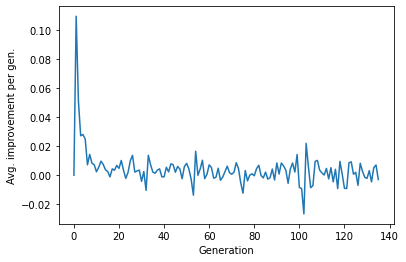

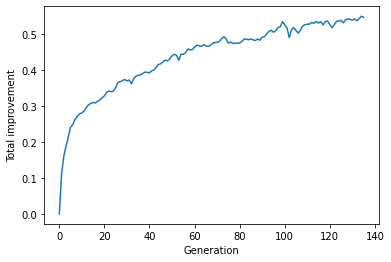

**************************************************************************************************** 
Generation 136/500
............................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0
..........
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is 0.004446039664801615
................
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is 0.001731076181438418
................................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is -0.023219272651073486
.............................Finished evaluating teritory 1
Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 3
.
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is -0.027685821709094727
Finished evaluating teritory 4
..
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is 0.0
Finished evaluating teritory 5
Need drift: 4
This gen

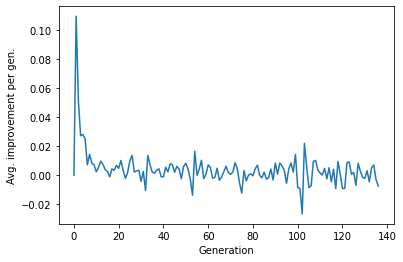

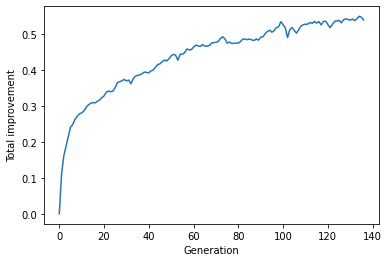

**************************************************************************************************** 
Generation 137/500
.................................................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is 0.012656877382996035
..............................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is .0.011508543812730032
............
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is 0.0
.......................................Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
.
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.0176843912228426
Finished evaluating teritory 3
.
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is -0.024256758914011356
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is 0.0
Finished evaluating teritory 5
Need drift: 3
This genera

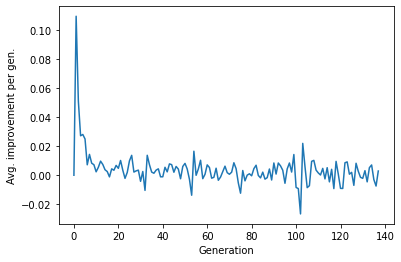

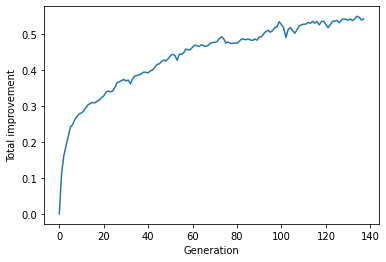

**************************************************************************************************** 
Generation 138/500
.............................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is 0.008202015118547568
......................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0
..........................................
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is 0.024382585059322448
..........
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.0
............................Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
..
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is -0.021713932316952067
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is 0.0
Finished evaluating teritory 5
Need drift: 4
This generation took 0:08:

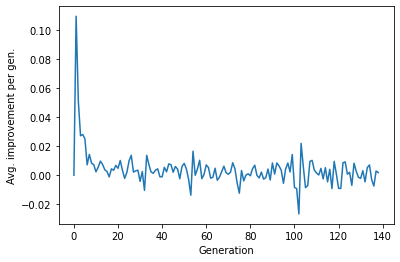

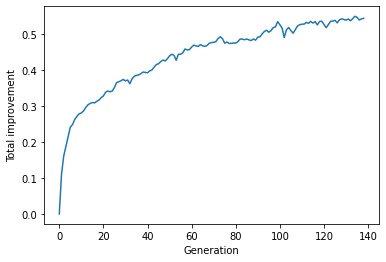

**************************************************************************************************** 
Generation 139/500
......................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is -0.03058659465215685
...........................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.026733208872465886
...........................
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is 0.005231325608396009
.............................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.014796636549478714
.....................
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is 0.011320341675983281
.....Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is -0.013144969443876553
Finished evaluating

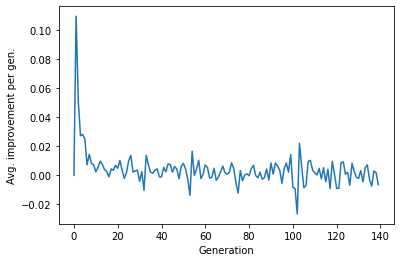

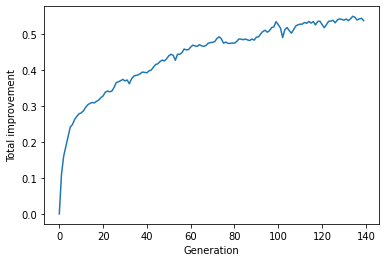

**************************************************************************************************** 
Generation 140/500
..........................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is 0.05813825591327415
........................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0018650001263258442
...........................................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.0
...........................
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is 0.024361933590330453
...........Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 2
..
Best MAE for teritory 4 is 26429.590453868324 . Average improvement is -0.004117090879147245
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is -0.03258810503546328
Finished evaluating teritory 5
Need d

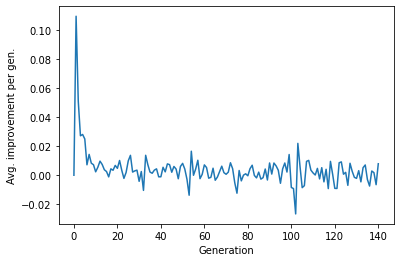

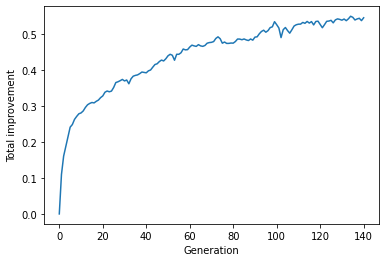

**************************************************************************************************** 
Generation 141/500
............................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is -0.012357560651316546
............................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is -0.048294743195358425
...........................
Best MAE for teritory 4 is 23002.470960918614 . Average improvement is 0.038400519115282084
...............................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.0
.Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 4
Finished evaluating teritory 3
.
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is 0.002544673346750237
Finished evaluating teritory 5
..
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is 0.0039881600202267276
Finished evaluating teritory 2
Need

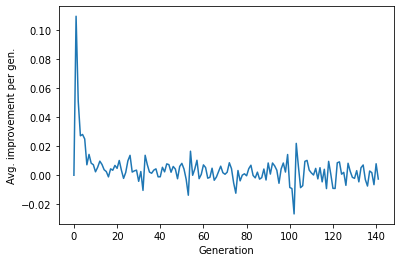

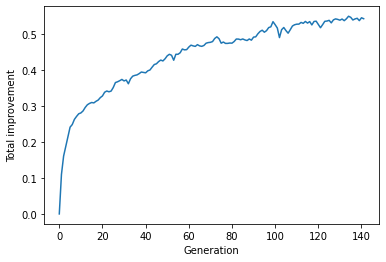

**************************************************************************************************** 
Generation 142/500
.....................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is 0.016344178278606014
................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.027463851797743466
...........................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.011758365065456688
.......
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is -0.06483006673324498
............................Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 3
Finished evaluating teritory 2
..
Best MAE for teritory 4 is 23002.470960918614 . Average improvement is 0.030921850410636553
Finished evaluating teritory 4
.
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is 0.0
Finished evaluating teritory 5
Need dr

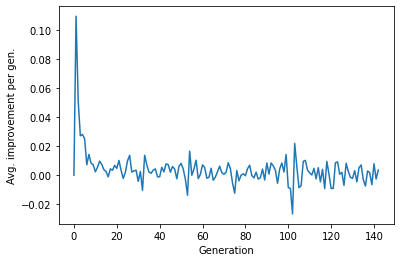

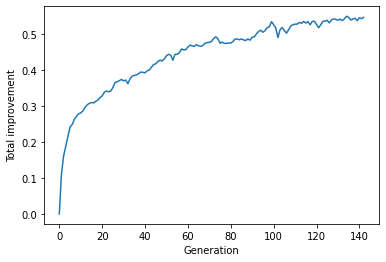

**************************************************************************************************** 
Generation 143/500
...........................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is 0.002759012343451106
....................................................
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is 0.031133871353770104
.................
Best MAE for teritory 3 is 25837.27028538813 . Average improvement is 0.0
.....
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.029949795113485278
.........................
Best MAE for teritory 4 is 23002.470960918614 . Average improvement is 0.0
.....Finished evaluating teritory 0
Finished evaluating teritory 2
Finished evaluating teritory 3
Finished evaluating teritory 1
Finished evaluating teritory 4
...
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is 0.0
Finished evaluating teritory 5
Need drift: 3
This generation took 0:06:3

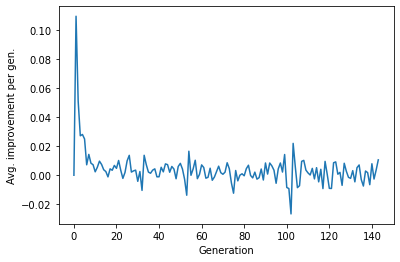

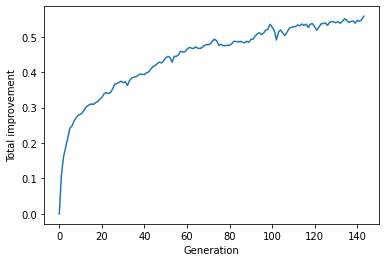

**************************************************************************************************** 
Generation 144/500
...............................................
Best MAE for teritory ...0 is 23314.14145430541... . Average improvement is 0.0
...............
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.0
.............................................
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is 0.0
....
Best MAE for teritory 3 is 23002.470960918614 . Average improvement is -0.0074184716196549205
..............................Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 3
..
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is -0.08566584279294176
Finished evaluating teritory 5
.
Best MAE for teritory 4 is 25463.56442545123 . Average improvement is -0.009693128410222962
Finished evaluating teritory 4
Need drift: 6
This generation took 0:0

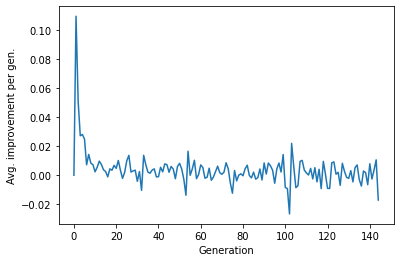

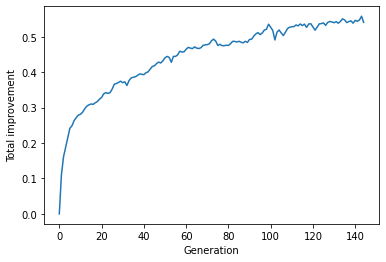

**************************************************************************************************** 
Generation 145/500
..........................................
Best MAE for teritory 0 is 23314.14145430541 . Average improvement is -0.015564509806732185
................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.013471683374649546
.
Best MAE for teritory 2 is 23957.28595890411 . Average improvement is 0.009205341320071003
...................................................
Best MAE for teritory 4 is 25463.56442545123 . Average improvement is 0.004241962535968868
.....Finished evaluating teritory 0
Finished evaluating teritory 1
Finished evaluating teritory 2
Finished evaluating teritory 4
.
Best MAE for teritory 3 is 23002.470960918614 . Average improvement is 0.0
Finished evaluating teritory 3
..
Best MAE for teritory 5 is 21312.52633793824 . Average improvement is -0.019409382361792127
Finished evaluating teritory 5
Need 

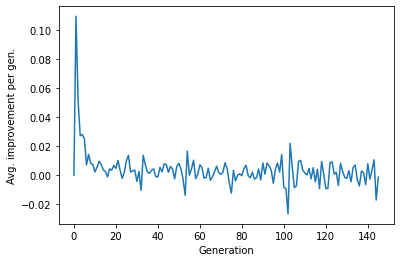

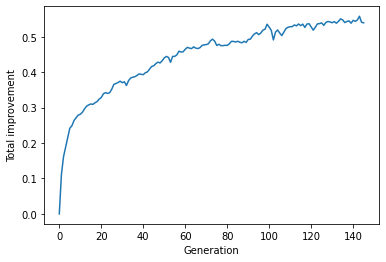

**************************************************************************************************** 
Generation 146/500
....................................................................
Best MAE for teritory 1 is 19014.63707952816 . Average improvement is 0.018146427617382166
......................

In [ ]:
# Hyper parameter tuning (using a genetic algorithm)

n_features = X_train_prepped.shape[1]
n_samples = X_train_prepped.shape[0]
pop_size = 25
n_generations = 500
n_territories = 6
n_survivors = int(0.5 * pop_size)
drift_threshold = 0.00001
small_step_mutation_rate = 0.1
large_step_mutation_rate = 0.01

param_limits = {
    'n_estimators':             (1, 1000),
    'max_depth':                (1, n_features),
    'min_samples_split':        (2, 1000),
    'min_samples_leaf':         (1, 1000),
    'min_weight_fraction_leaf': (0, 0.5),
    'max_features':             (1, n_features),
    'max_leaf_nodes':           (2, 10000),
    'min_impurity_decrease':    (0, 1),
    'bootstrap':                (True, False),
    'oob_score':                (True, False),
    'ccp_alpha':                (0, 1),
    'max_samples':              (1, n_samples),
}

"""
Format of ecosystem is:
{
  'last_generation': int,
  'times': [float,...],
  'improvements': [float,...],
  'average_total_improve': [float,...],
  'runtime_running_avg': float,
  'total_runtime': float,
  'avg_mae_survivors': [{
    'generation': int,
    'values': [None] * n_territories,
  }],
  'teritories': [
    [{hp:{}, mae=None},...],
    .
    .
    .
  ]
}
"""
ecosystem = {
    'last_generation': 0,
    'times': [],
    'improvements': [],
    'average_total_improve': [],
    'runtime_running_avg': 0,
    'total_runtime': 0,
    'avg_mae_survivors': [],
    'teritories': []
}


def init_env(ecosystem):
  teritories = []
  for i in range(n_territories):
    teritories.append([])
  ecosystem['teritories'] = teritories


def init_HP():
  """
  Provides a randomly initialized set of hyper parameters for a RandomForestRegressor
  """

  global n_features, n_samples, param_limits

  HP = {
      'n_estimators': int(random.randint(*param_limits['n_estimators'])),
      'max_depth': int(random.randint(*param_limits['max_depth'])),
      'min_samples_split': int(random.randint(*param_limits['min_samples_split'])),
      'min_samples_leaf': int(random.randint(*param_limits['min_samples_leaf'])),
      'min_weight_fraction_leaf': random.uniform(*param_limits['min_weight_fraction_leaf']),
      'max_features': int(random.randint(*param_limits['max_features'])),
      'max_leaf_nodes': int(random.randint(*param_limits['max_leaf_nodes'])),
      'min_impurity_decrease': random.uniform(*param_limits['min_impurity_decrease']),
      'bootstrap': bool(random.choice((True, False))),
      'oob_score': False,
      'ccp_alpha': random.uniform(*param_limits['ccp_alpha']),
      'max_samples': int(random.randint(*param_limits['max_samples'])),
  }

  if HP['bootstrap'] == True:
    HP['oob_score'] = bool(random.choice((True, False)))
  
  return HP


def evaluate_model(model, X_train, X_cv, y_train, y_cv):
  model.fit(X_train_prepped, y_train)
  pred = model.predict(X_cv_prepped)
  return mean_absolute_error(pred, y_cv)


def ragnge_size(limits):
  return limits[1] - limits[0]


def small_step_mutation(zygote):
  zygote['n_estimators'] = max(1, zygote['n_estimators'] + int(np.random.normal(0, ragnge_size(param_limits['n_estimators']) * small_step_mutation_rate)))
  zygote['max_depth'] = min(max(1, zygote['max_depth'] + int(np.random.normal(0, int(ragnge_size(param_limits['max_depth']) * small_step_mutation_rate)))), n_features)
  zygote['min_samples_split'] = max(2, zygote['min_samples_split'] + int(np.random.normal(0, ragnge_size(param_limits['min_samples_split']) * small_step_mutation_rate)))
  zygote['min_samples_leaf'] = max(1, zygote['min_samples_leaf'] + int(np.random.normal(0, ragnge_size(param_limits['min_samples_leaf']) * small_step_mutation_rate)))
  zygote['min_weight_fraction_leaf'] = min(max(0, zygote['min_weight_fraction_leaf'] + np.random.normal(0, ragnge_size(param_limits['min_weight_fraction_leaf']) * small_step_mutation_rate)), 0.5)
  zygote['max_features'] = min(max(1, zygote['max_features'] + int(np.random.normal(0, int(ragnge_size(param_limits['max_features']) * small_step_mutation_rate)))), n_features)
  zygote['max_leaf_nodes'] = max(2, zygote['max_leaf_nodes'] + int(np.random.normal(0, ragnge_size(param_limits['max_leaf_nodes']) * small_step_mutation_rate)))
  zygote['min_impurity_decrease'] += max(0, np.random.normal(0, ragnge_size(param_limits['min_impurity_decrease']) * small_step_mutation_rate))
  zygote['bootstrap'] = bool(np.random.choice([True, False], p=[1 - small_step_mutation_rate if x==zygote['bootstrap'] else small_step_mutation_rate for x in [True, False]]))
  zygote['oob_score'] = bool(np.random.choice([True, False], p=[1 - small_step_mutation_rate if x==zygote['oob_score'] else small_step_mutation_rate for x in [True, False]]))
  zygote['ccp_alpha'] = max(0, zygote['ccp_alpha'] + int(np.random.normal(0, ragnge_size(param_limits['ccp_alpha']) * small_step_mutation_rate)))
  zygote['max_samples'] = min(max(1, zygote['max_samples'] + int(np.random.normal(0, ragnge_size(param_limits['max_samples']) * small_step_mutation_rate))), n_samples)

  if zygote['bootstrap'] == False:
    zygote['oob_score'] = False
  
  return zygote


def should_do_large_step():
  return np.random.choice([True, False], p=[1 - large_step_mutation_rate, large_step_mutation_rate])


def large_step_mutation(zygote):
  global param_limits

  if should_do_large_step():
    zygote['n_estimators'] = int(random.randint(*param_limits['n_estimators']))
  if should_do_large_step():
    zygote['max_depth'] = int(random.randint(*param_limits['max_depth']))
  if should_do_large_step():
    zygote['min_samples_split'] = int(random.randint(*param_limits['min_samples_split']))
  if should_do_large_step():
    zygote['min_samples_leaf'] = int(random.randint(*param_limits['min_samples_leaf']))
  if should_do_large_step():
    zygote['min_weight_fraction_leaf'] = random.uniform(*param_limits['min_weight_fraction_leaf'])
  if should_do_large_step():
    zygote['max_features'] = int(random.randint(*param_limits['max_features']))
  if should_do_large_step():
    zygote['max_leaf_nodes'] = int(random.randint(*param_limits['max_leaf_nodes']))
  if should_do_large_step():
    zygote['min_impurity_decrease'] = random.uniform(*param_limits['min_impurity_decrease'])
  if should_do_large_step():
    zygote['bootstrap'] = bool(random.choice((True, False)))
  if should_do_large_step():
    zygote['oob_score'] = bool(random.choice((True, False)))
  if should_do_large_step():
    zygote['ccp_alpha'] = random.uniform(*param_limits['ccp_alpha'])
  if should_do_large_step():
    zygote['max_samples'] = int(random.randint(*param_limits['max_samples']))

  if zygote['bootstrap'] == False:
    zygote['oob_score'] = False
  
  return zygote


def mutate(zygote):
  zygote = small_step_mutation(zygote)
  zygote = large_step_mutation(zygote)
  return zygote


def fertilize(male, female):
  parents = [male, female]

  return mutate({
      'n_estimators': random.choice(parents)['hp']['n_estimators'],
      'max_depth': random.choice(parents)['hp']['max_depth'],
      'min_samples_split': random.choice(parents)['hp']['min_samples_split'],
      'min_samples_leaf': random.choice(parents)['hp']['min_samples_leaf'],
      'min_weight_fraction_leaf': random.choice(parents)['hp']['min_weight_fraction_leaf'],
      'max_features': random.choice(parents)['hp']['max_features'],
      'max_leaf_nodes': random.choice(parents)['hp']['max_leaf_nodes'],
      'min_impurity_decrease': random.choice(parents)['hp']['min_impurity_decrease'],
      'bootstrap': random.choice(parents)['hp']['bootstrap'],
      'oob_score': random.choice(parents)['hp']['oob_score'],
      'ccp_alpha': random.choice(parents)['hp']['ccp_alpha'],
      'max_samples': random.choice(parents)['hp']['max_samples'],
  })


def breed(population):
  male, female = random_gen.choice(population[:n_survivors], replace=False, size=2)
  return {'hp': fertilize(male, female), 'mae': None}


def perform_drift(teritories, idx):
  teritory_1 = teritories[idx]
  teritory_2 = random.choice([x for x in teritories if x is not teritory_1])
  specimen_1 = random_gen.choice(teritory_1)
  specimen_2 = random_gen.choice(teritory_2)
  teritory_1.remove(specimen_1)
  teritory_2.remove(specimen_2)
  teritory_1.append(specimen_2)
  teritory_2.append(specimen_1)


class Survivor:
  def __init__(self, hp, mae):
    self.hp = hp
    self.mae = mae
  
  def __lt__(self, other):
    return self.mae < other.mae
  
  def to_dict(self):
    return {'hp': self.hp, 'mae': self.mae}


def seconds2timestr(seconds): 
  hour = seconds // 3600
  seconds %= 3600
  minutes = seconds // 60
  seconds %= 60
  
  return "%d:%02d:%02d" % (hour, minutes, seconds)


def process_specimen(population, idx):
  global preped_X_train, preped_X_cv, y_train, y_cv
  if population[idx]['mae'] is None:
    model = model_from_hp(population[idx]['hp'])
    population[idx]['mae'] = evaluate_model(model, X_train_prepped, X_cv_prepped, y_train, y_cv)
  return population[idx]


def process_teritory(ecosystem, need_drift, idx, executor):
    teritories = ecosystem['teritories']
    futures = [executor.submit(process_specimen, teritories[idx], i) for i in range(len(teritories[idx]))]
    survivors = []
    for future in concurrent.futures.as_completed(futures):
        heapq.heappush(survivors, Survivor(**future.result()))
        print('.', end='')
    normal = random_gen.normal(0, n_survivors, size=len(teritories[idx]))
    abs_normal = np.abs(normal)
    probs = abs_normal / np.sum(abs_normal)
    sorted_probs = sorted(probs, reverse=True)
    for i in range(n_survivors, len(sorted_probs)):
      for j in range(n_survivors):
        sorted_probs[j] += sorted_probs[i] / 2
        sorted_probs[i] /= 2
    survivors = random_gen.choice(survivors, replace=False, size=n_survivors, p=sorted_probs)
    survivors = sorted(survivors.tolist())
    # survivors = heapq.nsmallest(n_survivors, survivors)
    new_avg_mae_survivors = np.mean([x.mae for x in survivors])
    try:
      improvement = ecosystem['avg_mae_survivors'][-2]['values'][idx] / new_avg_mae_survivors - 1
      if n_territories > 1 and improvement < drift_threshold:
        need_drift[idx] = True
    except Exception as ex:
      improvement = 0
    ecosystem['avg_mae_survivors'][-1]['values'][idx] = new_avg_mae_survivors
    print("\nBest MAE for teritory", idx, "is", survivors[0].mae, ". Average improvement is", improvement)
    teritories[idx] = [x.to_dict() for x in survivors]
    offsprings = []
    futures = [executor.submit(breed, teritories[idx]) for i in range((pop_size - len(teritories[idx])))]
    for future in concurrent.futures.as_completed(futures):
        offsprings.append(future.result())
    teritories[idx] += offsprings
    print("Finished evaluating teritory", idx)
    return improvement


try:
  with open(os.path.join(project_files_path, 'ecosystem.json')) as f:
    ecosystem = json.load(f)
    generations_passed = ecosystem['last_generation'] + 1
except Exception as e:
  for i in range(n_territories):
    ecosystem['teritories'].append([{'hp': init_HP(), 'mae': None} for i in range(int(pop_size))])
  generations_passed = 0

# Supress warnings to avoid terminal clutter
logging.captureWarnings(True)


with concurrent.futures.ThreadPoolExecutor() as executor:
  for generation in range(generations_passed, n_generations):
    print("*" * 100, "\nGeneration", str(generation) + '/' + str(n_generations))
    start_time = time.time()
    need_drift = [False] * n_territories
    ecosystem['avg_mae_survivors'].append({'generation': generation, 'values':[0] * n_territories})
    improvements = []
    futures = [executor.submit(process_teritory, ecosystem, need_drift, idx, executor) for idx in range(len(ecosystem['teritories']))]
    for future in concurrent.futures.as_completed(futures):
      improvements.append(future.result())
    average_improve = float(np.mean(improvements))
    try:
      ecosystem['average_total_improve'].append(ecosystem['average_total_improve'][-1] + average_improve)
    except:
      ecosystem['average_total_improve'].append(average_improve)
    ecosystem['improvements'].append(average_improve)
    sum_drifts = sum(need_drift)
    # n_survivors = max(MIN_SURVIVORS, min(pop_size - 5, n_survivors - 2 + sum_drifts))
    small_step_mutation_rate = 0.1 * (sum_drifts + 1)
    large_step_mutation_rate = 0.01 * (sum_drifts + 1)
    if n_territories > 1:
      print("Need drift:", sum_drifts) 
      for i in range(len(need_drift)):
        if need_drift[i] is True:
          perform_drift(ecosystem['teritories'], i)
    ecosystem['last_generation'] = generation
    end_time = time.time()
    generation_process_time = end_time - start_time
    ecosystem['total_runtime'] += generation_process_time
    ecosystem['runtime_running_avg'] = (ecosystem['runtime_running_avg'] + generation_process_time) / 2
    ecosystem['times'].append(generation_process_time)
    with open(os.path.join(project_files_path, 'ecosystem.json'), 'w') as f:
      json.dump(ecosystem, f)
    remaining_generations = n_generations - generation - 1
    print("This generation took", seconds2timestr(generation_process_time), "to process.")
    print("Remaining", remaining_generations, "generations and approximately", seconds2timestr(ecosystem['runtime_running_avg'] * remaining_generations))
    print("Average improvement for generation:", average_improve, ". Average total improvement:", ecosystem['average_total_improve'][-1])
    print("Total runtime:", seconds2timestr(ecosystem['total_runtime']))
    plt.plot(ecosystem['improvements'])
    plt.xlabel("Generation")
    plt.ylabel("Avg. improvement per gen.")
    plt.show()
    plt.plot(ecosystem['average_total_improve'])
    plt.xlabel("Generation")
    plt.ylabel("Total improvement")
    plt.show()
    

In [ ]:
# Prepeare test predictions
with open(os.path.join(project_files_path, 'ecosystem.json')) as f:
    ecosystem = json.load(f)

X_train_cv = pd.concat([preped_X_train, preped_X_cv], axis=0)
y_train_cv = pd.concat([y_train, y_cv], axis=0)

best_hp = ecosystem['teritories'][0][0]['hp']
best_mae = ecosystem['teritories'][0][0]['mae']
for teritory in ecosystem['teritories']:
  for specimen in teritory:
    if specimen['mae'] is not None and specimen['mae'] < best_mae:
      best_mae = specimen['mae']
      best_hp = specimen['hp']

print(best_hp)

model = model_from_hp(best_hp)

print("Fitting")

model.fit(X_train_cv, y_train_cv)

print("Predicting")

preds_test = model.predict(preped_X_test)

print("Saving")

output = pd.DataFrame({'Id': preped_X_test.Id.astype('int32'),
                       'SalePrice': preds_test})
output.to_csv(os.path.join(project_files_path, 'submission_gen.csv'), index=False)

In [ ]:
output = pd.DataFrame({'Id': preped_X_test.Id.astype('int32'),
                       'SalePrice': preds_test})
output.to_csv(os.path.join(project_files_path, 'submission_gen.csv'), index=False)